<a href="https://colab.research.google.com/github/phanng0605/End_to_End_Text_Sentiment_Classification/blob/main/End_to_End_Text_Sentiment_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import tensorflow as tf
import os

### See GPU usage

In [7]:
num_gpus_avail = len(tf.config.experimental.list_physical_devices('GPU'))
print('Num GPUs Available is: ', num_gpus_avail)
assert num_gpus_avail >= 0

sess = tf.compat.v1.Session(config = tf.compat.v1.ConfigProto(log_device_placement = True))
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

Num GPUs Available is:  1
Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5



## 1.  Gather Data

In [8]:
import pandas as pd
import numpy as np
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

In [9]:
dataset = tfds.load('amazon_us_reviews/Mobile_Electronics_v1_00', split = 'train', shuffle_files = True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/104975 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/amazon_us_reviews/Mobile_Electronics_v1_00/0.1.0.incompleteUU0HPA/amazon_u…

Dataset amazon_us_reviews downloaded and prepared to /root/tensorflow_datasets/amazon_us_reviews/Mobile_Electronics_v1_00/0.1.0. Subsequent calls will reuse this data.


## 2. Explore the data

In [10]:
dataset = tfds.as_dataframe(dataset)
dataset.head()

,data/customer_id,data/helpful_votes,data/marketplace,data/product_category,data/product_id,data/product_parent,data/product_title,data/review_body,data/review_date,data/review_headline,data/review_id,data/star_rating,data/total_votes,data/verified_purchase,data/vine
0,b'20980074',0,b'US',b'Mobile_Electronics',b'B00D1847NE',b'274617424',b'Teenage Mutant Ninja Turtles Boombox CD Play...,b'Does not work',b'2015-01-09',b'One Star',b'R1OVS0D6SEXPW7',1,0,0,1
1,b'779273',0,b'US',b'Mobile_Electronics',b'B00KMO6DYG',b'397452138',b'4 Gauge Amp Kit Amplifier Install Wiring Com...,b'This is a great wiring kit i used it to set ...,b'2015-08-06',b'Great kit',b'R9VSD0ET8FERB',4,0,0,1
2,b'15410531',0,b'US',b'Mobile_Electronics',b'B000GWLL0K',b'948304826',b'Travel Wall Charger fits Creative Zen Vision...,b'It works great so much faster than USB charg...,b'2007-03-15',b'A/C Charger for Creative Zen Vision M',b'R3ISXCZHWLJLBH',5,0,0,1
3,b'27389005',0,b'US',b'Mobile_Electronics',b'B008L3JE6Y',b'466340015',b'High Grade Robust 360\xc2\xb0 Adjustable Car...,b'This product was purchased to hold a monitor...,b'2013-07-30',b'camera stand',b'R1TWVUDOFJSQAW',5,0,0,1
4,b'2663569',0,b'US',b'Mobile_Electronics',b'B00GHZS4SC',b'350592810',b'HDE Multifunctional Bluetooth FM Audio Car K...,"b""it works but it has really bad sound quality...",b'2014-12-31',b'bad sound quality',b'R2PEOEUR1LP0GH',3,0,0,1


In [11]:
# Pick relevant columns
columns = ['data/review_body', 'data/star_rating']
data = dataset[columns]
data.head()

,data/review_body,data/star_rating
0,b'Does not work',1
1,b'This is a great wiring kit i used it to set ...,4
2,b'It works great so much faster than USB charg...,5
3,b'This product was purchased to hold a monitor...,5
4,"b""it works but it has really bad sound quality...",3


In [12]:
data['data/review_body'][1]

b'This is a great wiring kit i used it to set up my Pyle 2000 watt amp to 2 alpine subs and worked just fine. im not sure about the power cord and its length because my battery is in the back but the ground cord is a bit short and thats its only flaw and that why i gave it 4 stars. great kit'

#### I will use the data/review_body, extract its sentiment and try to predict the data/star_rating

In [13]:
print("Total number of samples: ", len(data))

Total number of samples:  104975


In [14]:
# Get the number of class (number of star rating)
print(" Number of class is: \n", data['data/star_rating'].value_counts())

 Number of class is: 
 5    52255
4    18088
1    17587
3     9734
2     7311
Name: data/star_rating, dtype: int64


In [15]:
# Number of words per sample
print('Number of words per sample is: ', np.mean(data['data/review_body'].apply(lambda x : len(x.split()))))

Number of words per sample is:  63.97938556799238


In [16]:
# Distribution of number of words per sample
print('Distribution of number of words per sample: ')
pd.DataFrame([len(s) for s in data['data/review_body']]).value_counts()

Distribution of number of words per sample: 


9        550
114      534
115      523
113      522
119      518
        ... 
2724       1
2729       1
2731       1
2732       1
16009      1
Length: 3079, dtype: int64

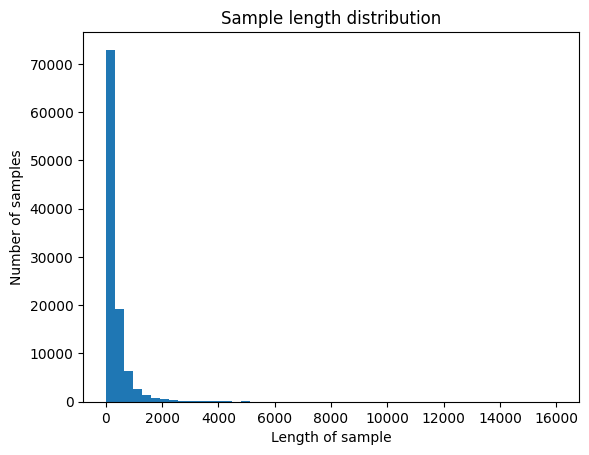

In [17]:
# Plotting
def plot_sample_length_distribution(sample_text):
  plt.hist([len(s) for s in sample_text], 50)
  plt.xlabel('Length of sample')
  plt.ylabel('Number of samples')
  plt.title('Sample length distribution')
  plt.show()

plot_sample_length_distribution(data['data/review_body'].tolist())

## 3. Prepare the data
* Feature engineering:
  1. Tokenization
  2. Vectorization
* Feature Selection

In [18]:
# Take sample of 30% of dataset for demonstration
data = data.sample(frac = 0.3, random_state = 42)
data.head()

,data/review_body,data/star_rating
87666,"b""The motor spins and is not stationary. That ...",3
47509,b'Fake',1
69877,"b""Even though there are finally some silicone ...",5
11951,"b""Absolutely Wonderful: This product is every...",5
73562,"b""Love this Bluetooth speaker...easy setup, wo...",5


In [19]:
print("number of datapoints after sampling: ", len(data))

number of datapoints after sampling:  31492


In [20]:
# Convert rating to sentiment
data['sentiment'] = data['data/star_rating'].apply(lambda rating: 'positive' if rating >= 3 else 'negative')
data.head()

,data/review_body,data/star_rating,sentiment
87666,"b""The motor spins and is not stationary. That ...",3,positive
47509,b'Fake',1,negative
69877,"b""Even though there are finally some silicone ...",5,positive
11951,"b""Absolutely Wonderful: This product is every...",5,positive
73562,"b""Love this Bluetooth speaker...easy setup, wo...",5,positive


In [21]:
# One-hot encode the target label
data['sentiment'] = data['sentiment'].map({'positive':1, 'negative': 0})
data.drop(columns = ['data/star_rating'], inplace = True)
data.head()

,data/review_body,sentiment
87666,"b""The motor spins and is not stationary. That ...",1
47509,b'Fake',0
69877,"b""Even though there are finally some silicone ...",1
11951,"b""Absolutely Wonderful: This product is every...",1
73562,"b""Love this Bluetooth speaker...easy setup, wo...",1


In [22]:
# Preprocessing the review
data.rename(columns = {'data/review_body': 'review'}, inplace = True)
data['review'] = data['review'].str.decode('utf-8')
data['review'] = data['review'].apply(str.lower)
data['review']
data.head()

,review,sentiment
87666,the motor spins and is not stationary. that se...,1
47509,fake,0
69877,even though there are finally some silicone ca...,1
11951,absolutely wonderful: this product is everyth...,1
73562,"love this bluetooth speaker...easy setup, wond...",1


In [23]:
#Check
data['sentiment'].value_counts()

1    24067
0     7425
Name: sentiment, dtype: int64

In [24]:
#Balance the classes for the purpose of demonstration
positive = data[data['sentiment'] == 1].sample(n = 7425, random_state = 42)
negative = data[data['sentiment'] == 0]
train_data = pd.concat([positive, negative]).sample(frac = 1).reset_index(drop = True)
train_data['sentiment'].value_counts()

0    7425
1    7425
Name: sentiment, dtype: int64

In [25]:
#Sample reviews and its corresponding labels
reviews = train_data['review'].tolist()
labels = train_data['sentiment'].tolist()

In [26]:
print("Sample reviews: ")
print(reviews[10:16])
print("Sample labels: ")
print(labels[10:16])

Sample reviews: 
["poor instructions, the buttons work when they want to, so far i have been unable to get it to record in segments.  i don't recommend this product.", 'above expectation<br />like all aspects<br />for the money, the oem replacement was an easy install and works great. thanks simplesoft', 'this product does not work well, the signal quality is the worst, the picture presented is very fuzzy, with lots of rain, it takes all the channels, video has no audio, i definitely feel hurt by this receiver, i feel i launched the money, i do not recommend buying it, too limited.', 'this product does not work. it doesn not charge our i-touch.  very disappointed.  we will have to purchase another charger from a local store.', "works with two differnt cords, one to the power and another to the headphone jack for newer iphones, not exactly convenient.  within 2 weeks of not common usage, the part the went into the iphone for the power stayed in the iphone when i pulled the cord out - it

In [27]:
#Split data into train, test and validation set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(reviews, labels, test_size = 0.2, random_state = 42)

In [28]:
#Number of train & test data
print("Number of train data points: ", len(X_train))
print("Number of train labels: ", len(y_train))
print("Number of test data points: ", len(X_test))
print("Number of test labels: ", len(y_test))

Number of train data points:  11880
Number of train labels:  11880
Number of test data points:  2970
Number of test labels:  2970


In [29]:
# Load tokenizer model
%pip install transformers
from transformers import DistilBertTokenizerFast

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 61.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 110.1 MB/s eta 0:00:00


In [30]:
MODEL_NAME = 'distilbert-base-uncased-finetuned-sst-2-english'
tokenizer = DistilBertTokenizerFast.from_pretrained(MODEL_NAME)

In [31]:
# Sample tokenization
print("Sentence: ", X_train[0])
tokenizer(X_train[0], truncation = True, padding = True, max_length = 256, return_tensors = 'tf')

Sentence:  wired new speakers for the boat and still have enough left for the jeep.  great product and great quality.  thanks


{'input_ids': <tf.Tensor: shape=(1, 24), dtype=int32, numpy=
array([[  101, 17502,  2047,  7492,  2005,  1996,  4049,  1998,  2145,
         2031,  2438,  2187,  2005,  1996, 14007,  1012,  2307,  4031,
         1998,  2307,  3737,  1012,  4283,   102]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(1, 24), dtype=int32, numpy=
array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1]], dtype=int32)>}

In [32]:
# Tokenization
MAX_LENGTH = 512
train_encodings = tokenizer(X_train, truncation = True, padding = True, return_tensors='tf',  max_length = MAX_LENGTH)
test_encodings = tokenizer(X_test, truncation = True, padding = True, return_tensors = 'tf', max_length = MAX_LENGTH)

In [33]:
train_encodings[0]

Encoding(num_tokens=512, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])

In [34]:
#convert tokenizer to tf object
train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((dict(test_encodings), y_test))

In [35]:
test_dataset

<_TensorSliceDataset element_spec=({'input_ids': TensorSpec(shape=(512,), dtype=tf.int32, name=None), 'attention_mask': TensorSpec(shape=(512,), dtype=tf.int32, name=None)}, TensorSpec(shape=(), dtype=tf.int32, name=None))>

## 4. Build, train and evaluate the model

#### * I am going to use transer learning, loading a pretrained <b>'distilbert model'</b> finetuned on SST-2 dataset.
#### * Evaluation: Metric, loss function, Optimizer

In [36]:
# Define the model - pretrained distilbert model
from transformers import TFDistilBertForSequenceClassification
model = TFDistilBertForSequenceClassification.from_pretrained(
    pretrained_model_name_or_path = MODEL_NAME,
    num_labels = 2
    )

All model checkpoint layers were used when initializing TFDistilBertForSequenceClassification.

All the layers of TFDistilBertForSequenceClassification were initialized from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


In [37]:
#optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate = 5e-5)

In [38]:
#loss function
loss_function = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)

In [39]:
#compile the model
model.compile(optimizer = optimizer, loss = loss_function, metrics = ['accuracy'])

In [40]:
model.summary()

Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMai  multiple                 66362880  
 nLayer)                                                         
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
 dropout_19 (Dropout)        multiple                  0         
                                                                 
Total params: 66,955,010
Trainable params: 66,955,010
Non-trainable params: 0
_________________________________________________________________


In [41]:
#Define hyperparameter
BATCH_SIZE = 16
EPOCHS = 2

In [42]:
#train model
model.fit(train_dataset.shuffle(len(X_train)).batch(BATCH_SIZE),
          epochs = EPOCHS,
          batch_size = BATCH_SIZE, 
          validation_data = test_dataset.shuffle(len(X_test)).batch(BATCH_SIZE)
          )

Epoch 1/2
743/743 [==============================] - 736s 934ms/step - loss: 0.2661 - accuracy: 0.8935 - val_loss: 0.2576 - val_accuracy: 0.9010
Epoch 2/2
743/743 [==============================] - 720s 969ms/step - loss: 0.1522 - accuracy: 0.9427 - val_loss: 0.2448 - val_accuracy: 0.9104


In [43]:
# Save trained model
model.save_pretrained("/tmp/sentiment_model")

In [44]:
#Preprocess unseen data
unseen_data = data.sample(frac = 0.05, random_state = 42)
unseen_reviews = unseen_data['review'].tolist()

unseen_encodings = tokenizer(unseen_reviews,
                             padding = True,
                             truncation = True,
                             max_length = MAX_LENGTH,
                             return_tensors = 'tf')

y_unseen = unseen_data['sentiment'].tolist()

unseen_encodings = tf.data.Dataset.from_tensor_slices((dict(unseen_encodings), y_unseen))

In [45]:
# Evaluate
model.evaluate(unseen_encodings.shuffle(len(unseen_reviews)).batch(BATCH_SIZE),
               return_dict = True,
               batch_size =BATCH_SIZE)

99/99 [==============================] - 30s 304ms/step - loss: 0.2151 - accuracy: 0.9092


{'loss': 0.21510900557041168, 'accuracy': 0.9092063307762146}

## 5.  Refine the model
To improve the modelm, I perform hyperparameter tuning:
  * Nums of layer (hidden layer)
  * Nums of units per layer - input layer should match the input size
  * Dropout rate
  * Learning rate 

Here we do not need to refine since the model's accuracy is decent (over 90% accuracy)

## 6. Deploy the model
Here I use Gradio to set the interface for interaction

In [46]:
%pip install gradio
import gradio as gr

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [47]:
def output(sentence):
  #load model
  loaded_model = TFDistilBertForSequenceClassification.from_pretrained("/tmp/sentiment_model")

  #Get prediction
  predict_input = tokenizer.encode(sentence,
                                   truncation = True,
                                   padding = True,
                                   return_tensors = 'tf')
  
  tf_output = loaded_model.predict(predict_input)[0]
  tf_prediction = tf.nn.softmax(tf_output, axis = 1).numpy()[0]
  return ['negative', 'positive'][np.argmax(tf_prediction)]

In [48]:
demo = gr.Interface(fn = output, inputs = 'text', outputs='text', live = True)

demo.launch()

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>